In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '맥주'만 빼서 df생성
item = '맥주'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


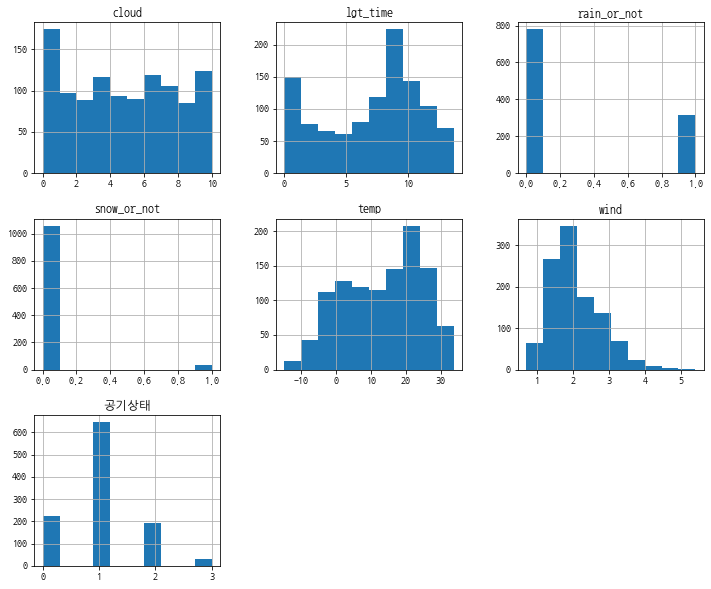

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

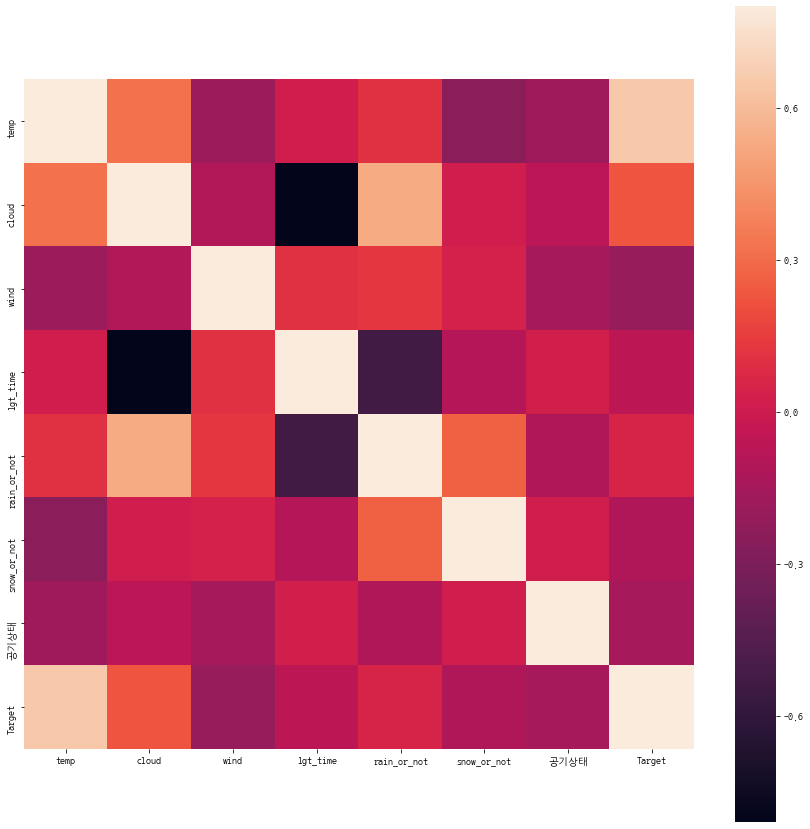

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [13]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [14]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [15]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [16]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0722 15:00:45.316926  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 15:00:45.333881  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 15:00:45.335876  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0722 15:00:45.395740  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [20]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 14:27:30.149129  6420 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 14:27:30.263823  6420 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 511us/step - loss: 11598.7261 - mean_absolute_error: 11598.7261 - val_loss: 11567.4067 - val_mean_absolute_error: 11567.4067

Epoch 00001: val_loss improved from inf to 11567.40669, saving model to 맥주date-Weights-001--11567.40669-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 82us/step - loss: 11016.7235 - mean_absolute_error: 11016.7235 - val_loss: 9551.6203 - val_mean_absolute_error: 9551.6203

Epoch 00002: val_loss improved from 11567.40669 to 9551.62026, saving model to 맥주date-Weights-002--9551.62026-cat02-vf05.hdf5
Epoch 3/1000
585/585 [==============================] - 0s 80us/step - loss: 5562.6278 - mean_absolute_error: 5562.6278 - val_loss: 3320.5820 - val_mean_absolute_error: 3320.5820

Epoch 00003: val_loss improved from 9551.62026 to 3320.58197, saving model to 맥주date-Weights-003--3320.58197-cat02-vf05.hdf5
Epoch 4/1000
585/585 [==============


Epoch 00032: val_loss did not improve from 1527.13177
Epoch 33/1000
585/585 [==============================] - 0s 82us/step - loss: 1689.3376 - mean_absolute_error: 1689.3376 - val_loss: 1557.8766 - val_mean_absolute_error: 1557.8766

Epoch 00033: val_loss did not improve from 1527.13177
Epoch 34/1000
585/585 [==============================] - 0s 102us/step - loss: 1700.4908 - mean_absolute_error: 1700.4908 - val_loss: 1569.0019 - val_mean_absolute_error: 1569.0019

Epoch 00034: val_loss did not improve from 1527.13177
Epoch 35/1000
585/585 [==============================] - 0s 82us/step - loss: 1705.2360 - mean_absolute_error: 1705.2360 - val_loss: 1617.8847 - val_mean_absolute_error: 1617.8847

Epoch 00035: val_loss did not improve from 1527.13177
Epoch 36/1000
585/585 [==============================] - 0s 73us/step - loss: 1681.7164 - mean_absolute_error: 1681.7164 - val_loss: 1607.6037 - val_mean_absolute_error: 1607.6037

Epoch 00036: val_loss did not improve from 1527.13177
Epoc

585/585 [==============================] - 0s 90us/step - loss: 1545.2804 - mean_absolute_error: 1545.2804 - val_loss: 1429.1908 - val_mean_absolute_error: 1429.1908

Epoch 00100: val_loss did not improve from 1392.29469
Epoch 101/1000
585/585 [==============================] - 0s 116us/step - loss: 1537.2948 - mean_absolute_error: 1537.2948 - val_loss: 1406.6687 - val_mean_absolute_error: 1406.6687

Epoch 00101: val_loss did not improve from 1392.29469
Epoch 102/1000
585/585 [==============================] - 0s 101us/step - loss: 1539.1024 - mean_absolute_error: 1539.1024 - val_loss: 1471.8692 - val_mean_absolute_error: 1471.8692

Epoch 00102: val_loss did not improve from 1392.29469
Epoch 103/1000
585/585 [==============================] - 0s 109us/step - loss: 1541.3060 - mean_absolute_error: 1541.3060 - val_loss: 1407.1919 - val_mean_absolute_error: 1407.1919

Epoch 00103: val_loss did not improve from 1392.29469
Epoch 104/1000
585/585 [==============================] - 0s 94us/st

585/585 [==============================] - 0s 121us/step - loss: 1598.6428 - mean_absolute_error: 1598.6428 - val_loss: 1376.7133 - val_mean_absolute_error: 1376.7133

Epoch 00168: val_loss did not improve from 1351.40218
Epoch 169/1000
585/585 [==============================] - 0s 123us/step - loss: 1508.6242 - mean_absolute_error: 1508.6242 - val_loss: 1424.1877 - val_mean_absolute_error: 1424.1877

Epoch 00169: val_loss did not improve from 1351.40218
Epoch 170/1000
585/585 [==============================] - 0s 121us/step - loss: 1515.6811 - mean_absolute_error: 1515.6811 - val_loss: 1398.1905 - val_mean_absolute_error: 1398.1905

Epoch 00170: val_loss did not improve from 1351.40218
Epoch 171/1000
585/585 [==============================] - 0s 143us/step - loss: 1497.9593 - mean_absolute_error: 1497.9593 - val_loss: 1404.3452 - val_mean_absolute_error: 1404.3452

Epoch 00171: val_loss did not improve from 1351.40218
Epoch 172/1000
585/585 [==============================] - 0s 136us/


Epoch 00202: val_loss did not improve from 1351.40218
Epoch 203/1000
585/585 [==============================] - 0s 123us/step - loss: 1478.0358 - mean_absolute_error: 1478.0358 - val_loss: 1576.3863 - val_mean_absolute_error: 1576.3863

Epoch 00203: val_loss did not improve from 1351.40218
Epoch 204/1000
585/585 [==============================] - 0s 126us/step - loss: 1503.5793 - mean_absolute_error: 1503.5793 - val_loss: 1383.4968 - val_mean_absolute_error: 1383.4968

Epoch 00204: val_loss did not improve from 1351.40218
Epoch 205/1000
585/585 [==============================] - 0s 118us/step - loss: 1472.0545 - mean_absolute_error: 1472.0545 - val_loss: 1408.7827 - val_mean_absolute_error: 1408.7827

Epoch 00205: val_loss did not improve from 1351.40218
Epoch 206/1000
585/585 [==============================] - 0s 124us/step - loss: 1463.1230 - mean_absolute_error: 1463.1230 - val_loss: 1413.5474 - val_mean_absolute_error: 1413.5474

Epoch 00206: val_loss did not improve from 1351.402


Epoch 00271: val_loss did not improve from 1351.40218
Epoch 272/1000
585/585 [==============================] - 0s 138us/step - loss: 1480.0192 - mean_absolute_error: 1480.0192 - val_loss: 1395.9049 - val_mean_absolute_error: 1395.9049

Epoch 00272: val_loss did not improve from 1351.40218
Epoch 273/1000
585/585 [==============================] - 0s 133us/step - loss: 1425.2884 - mean_absolute_error: 1425.2884 - val_loss: 1388.9254 - val_mean_absolute_error: 1388.9254

Epoch 00273: val_loss did not improve from 1351.40218
Epoch 274/1000
585/585 [==============================] - 0s 142us/step - loss: 1437.2773 - mean_absolute_error: 1437.2773 - val_loss: 1372.2897 - val_mean_absolute_error: 1372.2897

Epoch 00274: val_loss did not improve from 1351.40218
Epoch 275/1000
585/585 [==============================] - 0s 145us/step - loss: 1452.6020 - mean_absolute_error: 1452.6020 - val_loss: 1396.3931 - val_mean_absolute_error: 1396.3931

Epoch 00275: val_loss did not improve from 1351.402


Epoch 00340: val_loss did not improve from 1351.40218
Epoch 341/1000
585/585 [==============================] - 0s 140us/step - loss: 1411.3112 - mean_absolute_error: 1411.3112 - val_loss: 1387.5974 - val_mean_absolute_error: 1387.5974

Epoch 00341: val_loss did not improve from 1351.40218
Epoch 342/1000
585/585 [==============================] - 0s 143us/step - loss: 1410.7745 - mean_absolute_error: 1410.7745 - val_loss: 1409.4188 - val_mean_absolute_error: 1409.4188

Epoch 00342: val_loss did not improve from 1351.40218
Epoch 343/1000
585/585 [==============================] - 0s 140us/step - loss: 1406.2775 - mean_absolute_error: 1406.2775 - val_loss: 1396.9817 - val_mean_absolute_error: 1396.9817

Epoch 00343: val_loss did not improve from 1351.40218
Epoch 344/1000
585/585 [==============================] - 0s 133us/step - loss: 1453.6438 - mean_absolute_error: 1453.6438 - val_loss: 1383.8822 - val_mean_absolute_error: 1383.8822

Epoch 00344: val_loss did not improve from 1351.402

585/585 [==============================] - 0s 152us/step - loss: 1431.5059 - mean_absolute_error: 1431.5059 - val_loss: 1389.8139 - val_mean_absolute_error: 1389.8139

Epoch 00409: val_loss did not improve from 1351.40218
Epoch 410/1000
585/585 [==============================] - 0s 157us/step - loss: 1424.3030 - mean_absolute_error: 1424.3030 - val_loss: 1395.2383 - val_mean_absolute_error: 1395.2383

Epoch 00410: val_loss did not improve from 1351.40218
Epoch 411/1000
585/585 [==============================] - 0s 150us/step - loss: 1398.5078 - mean_absolute_error: 1398.5078 - val_loss: 1392.2563 - val_mean_absolute_error: 1392.2563

Epoch 00411: val_loss did not improve from 1351.40218
Epoch 412/1000
585/585 [==============================] - 0s 145us/step - loss: 1402.9768 - mean_absolute_error: 1402.9768 - val_loss: 1408.1544 - val_mean_absolute_error: 1408.1544

Epoch 00412: val_loss did not improve from 1351.40218
Epoch 413/1000
585/585 [==============================] - 0s 157us/


Epoch 00443: val_loss did not improve from 1351.40218
Epoch 444/1000
585/585 [==============================] - 0s 148us/step - loss: 1420.0599 - mean_absolute_error: 1420.0599 - val_loss: 1423.6718 - val_mean_absolute_error: 1423.6718

Epoch 00444: val_loss did not improve from 1351.40218
Epoch 445/1000
585/585 [==============================] - 0s 155us/step - loss: 1418.2918 - mean_absolute_error: 1418.2918 - val_loss: 1410.1629 - val_mean_absolute_error: 1410.1629

Epoch 00445: val_loss did not improve from 1351.40218
Epoch 446/1000
585/585 [==============================] - 0s 143us/step - loss: 1433.6577 - mean_absolute_error: 1433.6577 - val_loss: 1666.4545 - val_mean_absolute_error: 1666.4545

Epoch 00446: val_loss did not improve from 1351.40218
Epoch 447/1000
585/585 [==============================] - 0s 147us/step - loss: 1533.1395 - mean_absolute_error: 1533.1395 - val_loss: 1558.2055 - val_mean_absolute_error: 1558.2055

Epoch 00447: val_loss did not improve from 1351.402


Epoch 00512: val_loss did not improve from 1351.40218
Epoch 513/1000
585/585 [==============================] - 0s 159us/step - loss: 1375.8704 - mean_absolute_error: 1375.8704 - val_loss: 1439.4734 - val_mean_absolute_error: 1439.4734

Epoch 00513: val_loss did not improve from 1351.40218
Epoch 514/1000
585/585 [==============================] - 0s 170us/step - loss: 1388.3059 - mean_absolute_error: 1388.3059 - val_loss: 1420.5512 - val_mean_absolute_error: 1420.5512

Epoch 00514: val_loss did not improve from 1351.40218
Epoch 515/1000
585/585 [==============================] - 0s 159us/step - loss: 1385.8186 - mean_absolute_error: 1385.8186 - val_loss: 1473.4596 - val_mean_absolute_error: 1473.4596

Epoch 00515: val_loss did not improve from 1351.40218
Epoch 516/1000
585/585 [==============================] - 0s 155us/step - loss: 1397.2892 - mean_absolute_error: 1397.2892 - val_loss: 1415.1848 - val_mean_absolute_error: 1415.1848

Epoch 00516: val_loss did not improve from 1351.402

585/585 [==============================] - 0s 188us/step - loss: 1357.3976 - mean_absolute_error: 1357.3976 - val_loss: 1443.6167 - val_mean_absolute_error: 1443.6167

Epoch 00581: val_loss did not improve from 1351.40218
Epoch 582/1000
585/585 [==============================] - 0s 172us/step - loss: 1355.5549 - mean_absolute_error: 1355.5549 - val_loss: 1440.1396 - val_mean_absolute_error: 1440.1396

Epoch 00582: val_loss did not improve from 1351.40218
Epoch 583/1000
585/585 [==============================] - 0s 148us/step - loss: 1376.8377 - mean_absolute_error: 1376.8377 - val_loss: 1492.3443 - val_mean_absolute_error: 1492.3443

Epoch 00583: val_loss did not improve from 1351.40218
Epoch 584/1000
585/585 [==============================] - 0s 148us/step - loss: 1392.7065 - mean_absolute_error: 1392.7065 - val_loss: 1449.9559 - val_mean_absolute_error: 1449.9559

Epoch 00584: val_loss did not improve from 1351.40218
Epoch 585/1000
585/585 [==============================] - 0s 159us/


Epoch 00649: val_loss did not improve from 1351.40218
Epoch 650/1000
585/585 [==============================] - 0s 150us/step - loss: 1349.7630 - mean_absolute_error: 1349.7630 - val_loss: 1494.5725 - val_mean_absolute_error: 1494.5725

Epoch 00650: val_loss did not improve from 1351.40218
Epoch 651/1000
585/585 [==============================] - 0s 159us/step - loss: 1335.4627 - mean_absolute_error: 1335.4627 - val_loss: 1480.3316 - val_mean_absolute_error: 1480.3316

Epoch 00651: val_loss did not improve from 1351.40218
Epoch 652/1000
585/585 [==============================] - 0s 150us/step - loss: 1359.6857 - mean_absolute_error: 1359.6857 - val_loss: 1499.3999 - val_mean_absolute_error: 1499.3999

Epoch 00652: val_loss did not improve from 1351.40218
Epoch 653/1000
585/585 [==============================] - 0s 155us/step - loss: 1410.7246 - mean_absolute_error: 1410.7246 - val_loss: 1464.0372 - val_mean_absolute_error: 1464.0372

Epoch 00653: val_loss did not improve from 1351.402

585/585 [==============================] - 0s 143us/step - loss: 1342.5948 - mean_absolute_error: 1342.5948 - val_loss: 1502.8859 - val_mean_absolute_error: 1502.8859

Epoch 00718: val_loss did not improve from 1351.40218
Epoch 719/1000
585/585 [==============================] - 0s 138us/step - loss: 1342.4816 - mean_absolute_error: 1342.4816 - val_loss: 1495.0564 - val_mean_absolute_error: 1495.0564

Epoch 00719: val_loss did not improve from 1351.40218
Epoch 720/1000
585/585 [==============================] - 0s 157us/step - loss: 1315.4331 - mean_absolute_error: 1315.4331 - val_loss: 1524.9405 - val_mean_absolute_error: 1524.9405

Epoch 00720: val_loss did not improve from 1351.40218
Epoch 721/1000
585/585 [==============================] - 0s 155us/step - loss: 1310.3469 - mean_absolute_error: 1310.3469 - val_loss: 1497.7173 - val_mean_absolute_error: 1497.7173

Epoch 00721: val_loss did not improve from 1351.40218
Epoch 722/1000
585/585 [==============================] - 0s 142us/


Epoch 00752: val_loss did not improve from 1351.40218
Epoch 753/1000
585/585 [==============================] - 0s 143us/step - loss: 1321.2198 - mean_absolute_error: 1321.2198 - val_loss: 1606.7041 - val_mean_absolute_error: 1606.7041

Epoch 00753: val_loss did not improve from 1351.40218
Epoch 754/1000
585/585 [==============================] - 0s 153us/step - loss: 1346.6134 - mean_absolute_error: 1346.6134 - val_loss: 1501.3418 - val_mean_absolute_error: 1501.3418

Epoch 00754: val_loss did not improve from 1351.40218
Epoch 755/1000
585/585 [==============================] - 0s 140us/step - loss: 1315.3117 - mean_absolute_error: 1315.3117 - val_loss: 1546.8377 - val_mean_absolute_error: 1546.8377

Epoch 00755: val_loss did not improve from 1351.40218
Epoch 756/1000
585/585 [==============================] - 0s 153us/step - loss: 1303.3480 - mean_absolute_error: 1303.3480 - val_loss: 1499.5830 - val_mean_absolute_error: 1499.5830

Epoch 00756: val_loss did not improve from 1351.402


Epoch 00821: val_loss did not improve from 1351.40218
Epoch 822/1000
585/585 [==============================] - 0s 159us/step - loss: 1285.3488 - mean_absolute_error: 1285.3488 - val_loss: 1586.4719 - val_mean_absolute_error: 1586.4719

Epoch 00822: val_loss did not improve from 1351.40218
Epoch 823/1000
585/585 [==============================] - 0s 155us/step - loss: 1276.0872 - mean_absolute_error: 1276.0872 - val_loss: 1615.9400 - val_mean_absolute_error: 1615.9400

Epoch 00823: val_loss did not improve from 1351.40218
Epoch 824/1000
585/585 [==============================] - 0s 177us/step - loss: 1264.1337 - mean_absolute_error: 1264.1337 - val_loss: 1599.6359 - val_mean_absolute_error: 1599.6359

Epoch 00824: val_loss did not improve from 1351.40218
Epoch 825/1000
585/585 [==============================] - 0s 162us/step - loss: 1279.4317 - mean_absolute_error: 1279.4317 - val_loss: 1615.0901 - val_mean_absolute_error: 1615.0901

Epoch 00825: val_loss did not improve from 1351.402


Epoch 00890: val_loss did not improve from 1351.40218
Epoch 891/1000
585/585 [==============================] - 0s 143us/step - loss: 1253.1386 - mean_absolute_error: 1253.1386 - val_loss: 1602.1616 - val_mean_absolute_error: 1602.1616

Epoch 00891: val_loss did not improve from 1351.40218
Epoch 892/1000
585/585 [==============================] - 0s 162us/step - loss: 1232.9630 - mean_absolute_error: 1232.9630 - val_loss: 1608.1730 - val_mean_absolute_error: 1608.1730

Epoch 00892: val_loss did not improve from 1351.40218
Epoch 893/1000
585/585 [==============================] - 0s 182us/step - loss: 1239.2067 - mean_absolute_error: 1239.2067 - val_loss: 1642.1687 - val_mean_absolute_error: 1642.1687

Epoch 00893: val_loss did not improve from 1351.40218
Epoch 894/1000
585/585 [==============================] - 0s 159us/step - loss: 1271.1597 - mean_absolute_error: 1271.1597 - val_loss: 1582.4079 - val_mean_absolute_error: 1582.4079

Epoch 00894: val_loss did not improve from 1351.402


Epoch 00959: val_loss did not improve from 1351.40218
Epoch 960/1000
585/585 [==============================] - 0s 152us/step - loss: 1195.5452 - mean_absolute_error: 1195.5452 - val_loss: 1609.1834 - val_mean_absolute_error: 1609.1834

Epoch 00960: val_loss did not improve from 1351.40218
Epoch 961/1000
585/585 [==============================] - 0s 150us/step - loss: 1198.7379 - mean_absolute_error: 1198.7379 - val_loss: 1593.4767 - val_mean_absolute_error: 1593.4767

Epoch 00961: val_loss did not improve from 1351.40218
Epoch 962/1000
585/585 [==============================] - 0s 167us/step - loss: 1206.6138 - mean_absolute_error: 1206.6138 - val_loss: 1598.5239 - val_mean_absolute_error: 1598.5239

Epoch 00962: val_loss did not improve from 1351.40218
Epoch 963/1000
585/585 [==============================] - 0s 172us/step - loss: 1208.9242 - mean_absolute_error: 1208.9242 - val_loss: 1600.5180 - val_mean_absolute_error: 1600.5180

Epoch 00963: val_loss did not improve from 1351.402

In [18]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '맥주date-Weights-142--1351.40218-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

W0722 15:00:53.088989  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 15:00:53.089959  7500 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [19]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.891
검증세트점수 : -1.304
XGBoost을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.661
검증세트점수 : -1.226
LinearRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080
RidgeRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.445
검증세트점수 : -1.067
LassoRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080
OLS을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080


In [20]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
customF = 'qty ~ temp'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

맥주 ols model
사람이 직접 식을 때려 박았을때 : -0.782


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     538.8
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.08e-89
Time:                        15:00:53   Log-Likelihood:                -6578.7
No. Observations:                 732   AIC:                         1.316e+04
Df Residuals:                     730   BIC:                         1.317e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9604.9167    112.478     85.394      0.000    9384.098    9825.736
temp         151.1586      6.512     23.212      0.000     138.374     163.944
==============================================================================
Omnibus:                        3.870   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.872
Skew:                           0.152   Prob(JB):                        0.144
Kurtosis:                       2.814   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [22]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.15
Linear 모델 MAPE 		: 0.17
Ridge 모델 MAPE 		: 0.17
Lasso 모델 MAPE 		: 0.17
OLS 모델 MAPE 			: 0.16


In [23]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(1094,)

In [24]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,12811,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [25]:
print(Xy.shape)
print(result_df.shape)

(1094, 12)
(1094, 16)


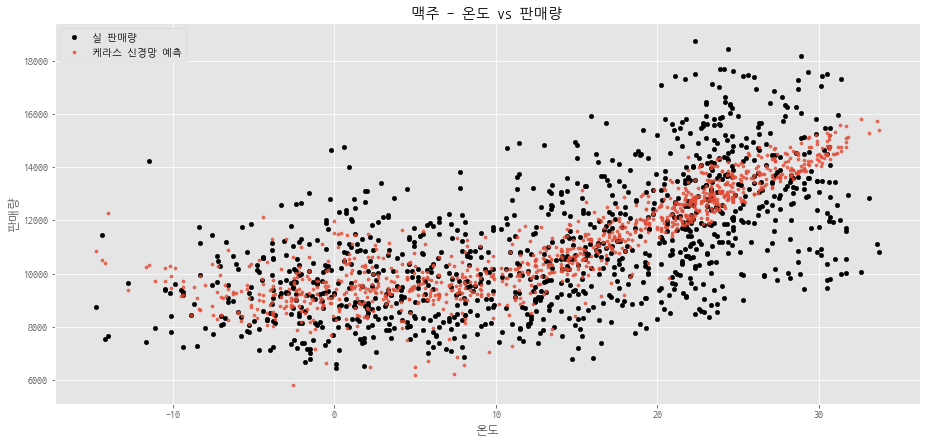

In [26]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [27]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

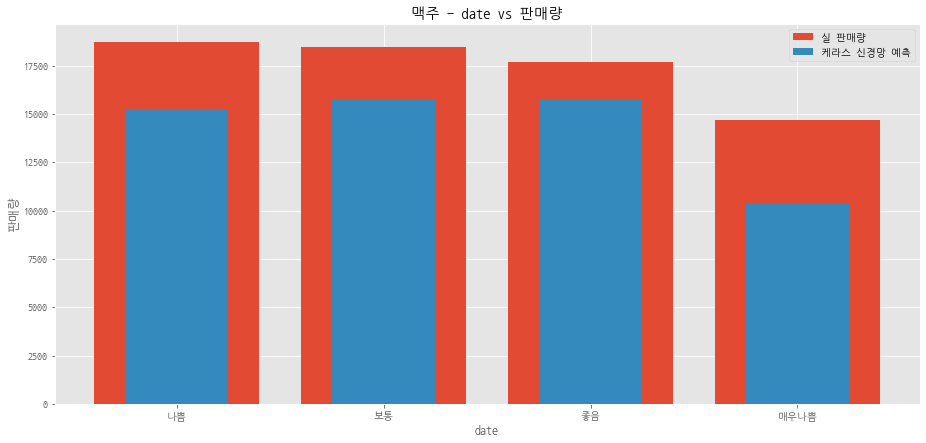

In [28]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [29]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [30]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,12811,10597.168945,12364.1,10823.410156,10405.709233,10504.552019,10404.417181,9786.306982,0.172807,...,0.180037,0.187853,0.236101,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,11813,10058.001953,10701.2,10327.002930,10561.092955,10738.234251,10560.285359,10466.520673,0.148565,...,0.090982,0.106045,0.113983,5.7,7.8,2.0,3.6,0,0,보통


In [31]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [32]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,12811,10597.168945,12364.1,10823.410156,10405.709233,10504.552019,10404.417181,9786.306982,0.172807,...,0.187853,0.236101,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,11813,10058.001953,10701.2,10327.002930,10561.092955,10738.234251,10560.285359,10466.520673,0.148565,...,0.106045,0.113983,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,11476,10617.088867,11249.6,11232.319336,11146.638365,11153.181571,11145.309280,10587.447552,0.074844,...,0.028816,0.077427,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,8663,8423.988281,9878.2,8942.507812,9624.074772,9863.802113,9623.725914,9907.233860,0.027590,...,0.110900,0.143626,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,8497,8966.845703,9918.9,9993.339844,9046.125210,9339.864332,9045.970646,9196.788449,0.055295,...,0.064608,0.082357,-2.7,3.4,2.3,7.9,0,0,보통,1


In [33]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
temp_cat,,,,,,,,
0,118869,1.333147e+05,9.836363e+04,9.836269e+04,1.012983e+05,139819.2,1.030104e+05,1.407873e+05
1,1498244,1.460918e+06,1.450618e+06,1.450673e+06,1.440916e+06,1536381.0,1.483749e+06,1.539015e+06
2,2471716,2.437014e+06,2.665409e+06,2.665359e+06,2.640884e+06,2564322.8,2.706218e+06,2.587055e+06
3,2911216,2.912481e+06,3.212100e+06,3.211993e+06,3.211748e+06,3052654.7,3.217405e+06,3.049822e+06
4,4611852,4.680544e+06,4.754908e+06,4.755007e+06,4.724439e+06,4851399.5,4.704529e+06,4.858399e+06
5,508010,5.929557e+05,5.753448e+05,5.753609e+05,5.717240e+05,596577.6,5.635997e+05,6.066810e+05


In [34]:
# 8개 판매량

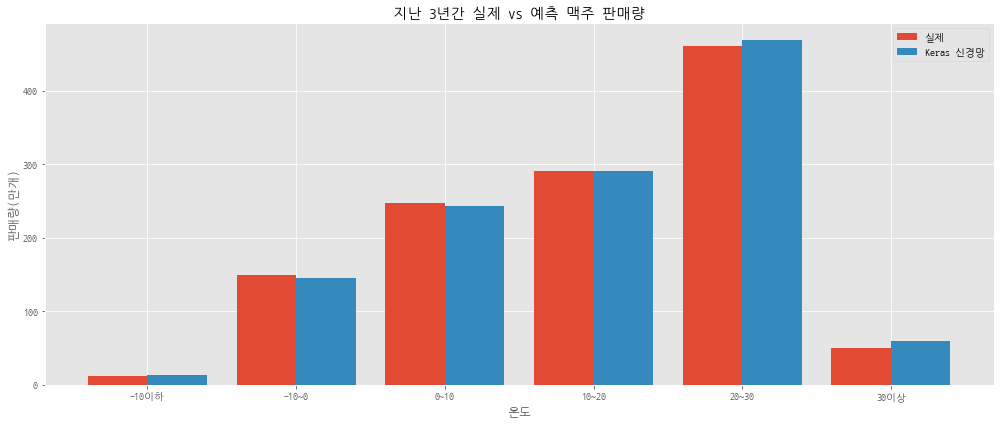

In [35]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty/10000, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty/10000, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('지난 3년간 실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량(만개)')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()